<a href="https://colab.research.google.com/github/HCI-hope/HCI-Models/blob/main/Implement_LSTM_BPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM & BPNN implimentation of whole data set of Subject1**



**LSTM Results:**
  Train Accuracy: 0.6648 ||
  Test Accuracy:  0.6739



**BPNN Results:**
  Train Accuracy: 0.9396 ||
  Test Accuracy:  0.6739

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
🚀 Training on WORD + LETTER + ARROW folders...
📁 Found 3 folders: ['WORD', 'LETTER', 'ARROW']

🔄 Processing folder: WORD
📄 Found 4 Excel files
🏷️  Assigned label: 1 (WORD-class)
✅ Loaded 19 windows from Cheby_WORD_Forward.xlsx
✅ Loaded 19 windows from Cheby_WORD_Right.xlsx
✅ Loaded 19 windows from Cheby_WORD_Backword.xlsx
✅ Loaded 19 windows from Cheby_WORD_Left.xlsx

🔄 Processing folder: LETTER
📄 Found 4 Excel files
🏷️  Assigned label: 0 (LETTER/ARROW-class)
✅ Loaded 19 windows from Cheby_LETTER_Backward.xlsx
✅ Loaded 19 windows from Cheby_LETTER_Forward.xlsx
✅ Loaded 19 windows from Cheby_LETTER_Left.xlsx
✅ Loaded 19 windows from Cheby_LETTER_Right.xlsx

🔄 Processing folder: ARROW
📄 Found 4 Excel files
🏷️  Assigned label: 0 (LETTER/ARROW-class)
✅ Loaded 19 windows from Cheby_ARROW_Forward.xlsx
✅ Loaded 19 windows from Ch

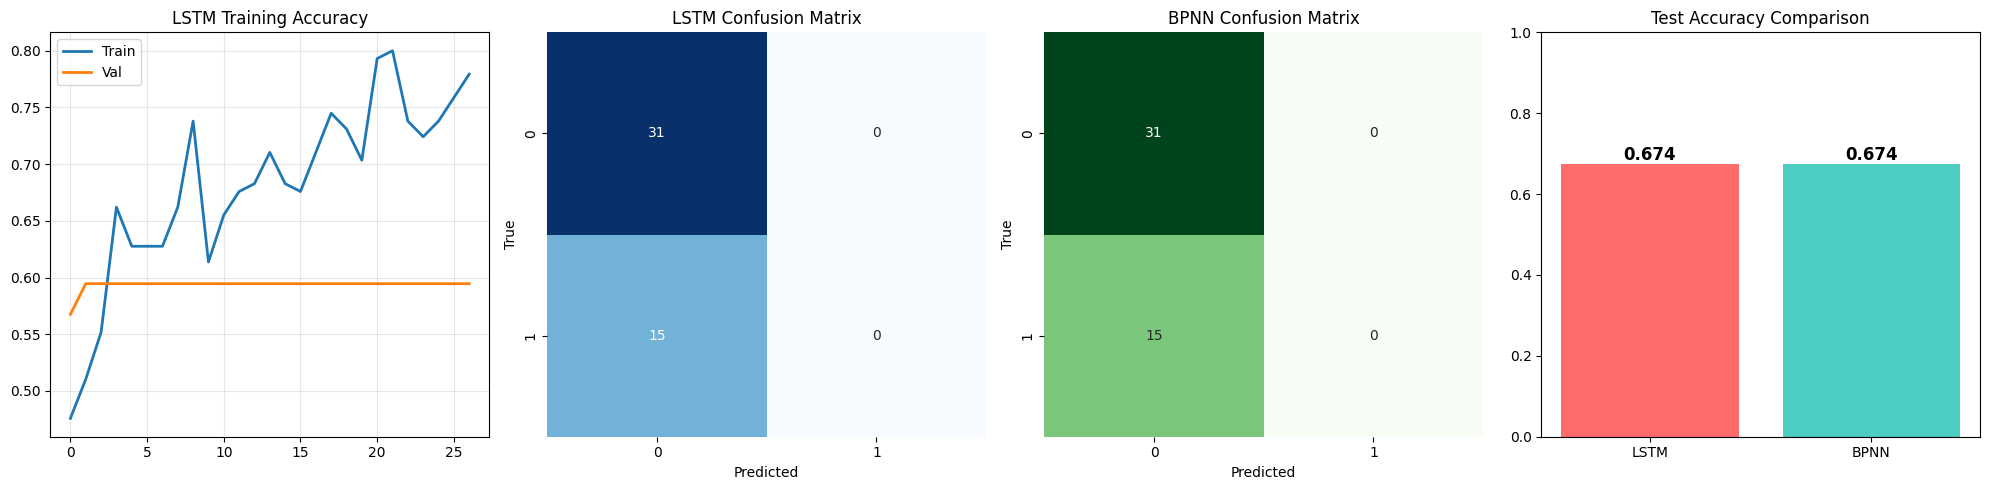


🎉 SUCCESS! Models saved to Google Drive:
   ✅ lstm_2ch_3folders_best.h5
   ✅ bpnn_2ch_3folders_best.pkl
   ✅ scaler_2ch_3folders.pkl
   ✅ lstm_bpnn_3folders_results.png


In [ ]:
# ===== GOOGLE COLAB + GOOGLE DRIVE SETUP =====
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Google Drive mounted successfully!")

# ===== CONFIGURATION =====
FOLDERS_PATH = '/content/drive/MyDrive/Human Computer Interface (HCI)/Processed_Filtered_Data/Subject1_Chebyshev_Filtered'
CHANNELS = [7, 9]  #
WINDOW_SIZE = 1000
OVERLAP = 0.5
TEST_SIZE = 0.2

# ===== FIXED LABEL MAPPING FOR YOUR 3 FOLDERS =====
LABEL_MAPPING = {
    'WORD': 1,
    'LETTER': 0,    # NEW: LETTER as class 0
    'ARROW': 0      # NEW: ARROW as class 0
}

# ===== IMPROVED DATA LOADING =====
def load_all_folders_data(base_path):
    """Load all Excel files from 3 folders"""
    all_X, all_y = [], []

    folders = [f.path for f in os.scandir(base_path) if f.is_dir()]
    print(f"📁 Found {len(folders)} folders: {[os.path.basename(f) for f in folders]}")

    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        print(f"\n🔄 Processing folder: {folder_name}")

        excel_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
        print(f"📄 Found {len(excel_files)} Excel files")

        # FIXED: Better label matching
        folder_label = None
        for label_name, label_id in LABEL_MAPPING.items():
            if label_name.lower() in folder_name.lower():
                folder_label = label_id
                break

        if folder_label is None:
            print(f"⚠️  No label mapping for '{folder_name}'. Assigning default label 0.")
            folder_label = 0  # Default label instead of skipping

        print(f"🏷️  Assigned label: {folder_label} ({'WORD-class' if folder_label==1 else 'LETTER/ARROW-class'})")

        for file_path in excel_files:
            try:
                X_windows, y_windows = load_single_file(file_path, folder_label)
                all_X.extend(X_windows)
                all_y.extend(y_windows)
                print(f"✅ Loaded {len(X_windows)} windows from {os.path.basename(file_path)}")
            except Exception as e:
                print(f"❌ Error: {e}")

    X = np.array(all_X)
    y = np.array(all_y)

    print(f"\n🎯 RAW DATA LOADED: {len(X)} samples, Labels: {np.bincount(y)}")
    return X, y

def load_single_file(file_path, label):
    df = pd.read_excel(file_path)
    data = df.iloc[:, CHANNELS].values.T

    step = int(WINDOW_SIZE * OVERLAP)
    X, y = [], []

    for i in range(0, data.shape[1] - WINDOW_SIZE, step):
        window = data[:, i:i+WINDOW_SIZE]
        if np.isnan(window).any() or np.isinf(window).any():
            continue
        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)

# ===== LSTM MODEL (HIGHER ACCURACY) =====
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')  # Fixed: Always 2 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0008),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ===== BPNN MODEL (HIGHER ACCURACY) =====
def create_bpnn_model(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))

    bpnn = MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64),  # Bigger for better accuracy
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=32,
        learning_rate='adaptive',
        max_iter=2000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )

    bpnn.fit(X_train_scaled, y_train)
    return bpnn, scaler

# ===== FIXED MAIN FUNCTION =====
def main():
    print("🚀 Training on WORD + LETTER + ARROW folders...")

    X, y = load_all_folders_data(FOLDERS_PATH)

    if len(X) == 0:
        print("❌ No data! Check paths.")
        return

    # Reshape for LSTM
    X_lstm = X.transpose(0, 2, 1)

    print(f"\n📊 FINAL DATASET:")
    print(f"   Total samples: {X.shape[0]}")
    print(f"   Shape: {X.shape}")
    print(f"   Classes: {np.unique(y)} | Distribution: {np.bincount(y)}")

    # Stratified split (handles imbalanced data)
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
        X_lstm, y, test_size=TEST_SIZE, random_state=42, stratify=y
    )

    X_train_bpnn, X_test_bpnn, _, _ = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=42, stratify=y
    )

    print(f"\n✅ Train: {X_train_lstm.shape[0]}, Test: {X_test_lstm.shape[0]}")

    # === LSTM TRAINING ===
    print("\n🔥 Training LSTM...")
    lstm_model = create_lstm_model((X_lstm.shape[1], X_lstm.shape[2]))

    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=150,
        batch_size=32,  # Smaller batch = better accuracy
        validation_split=0.2,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.3, min_lr=1e-6)
        ]
    )

    # FIXED EVALUATION
    lstm_train_acc = lstm_model.evaluate(X_train_lstm, y_train_lstm, verbose=0)[1]
    lstm_test_acc = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)[1]
    y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm, verbose=0), axis=1)

    # FIXED: Dynamic target names based on actual classes
    class_names = ['LETTER/ARROW', 'WORD'] if len(np.unique(y)) == 2 else ['Class_0']

    print(f"\n🏆 LSTM Results:")
    print(f"   Train Accuracy: {lstm_train_acc:.4f}")
    print(f"   Test Accuracy:  {lstm_test_acc:.4f}")
    print("\nLSTM Classification Report:")
    print(classification_report(y_test_lstm, y_pred_lstm, target_names=class_names))

    # === BPNN TRAINING ===
    print("\n🧠 Training BPNN...")
    bpnn_model, scaler = create_bpnn_model(X_train_bpnn, y_train_lstm)

    X_test_bpnn_scaled = scaler.transform(X_test_bpnn.reshape(X_test_bpnn.shape[0], -1))
    bpnn_train_pred = bpnn_model.predict(scaler.transform(X_train_bpnn.reshape(X_train_bpnn.shape[0], -1)))
    bpnn_test_pred = bpnn_model.predict(X_test_bpnn_scaled)

    bpnn_train_acc = accuracy_score(y_train_lstm, bpnn_train_pred)
    bpnn_test_acc = accuracy_score(y_test_lstm, bpnn_test_pred)

    print(f"\n🏆 BPNN Results:")
    print(f"   Train Accuracy: {bpnn_train_acc:.4f}")
    print(f"   Test Accuracy:  {bpnn_test_acc:.4f}")
    print("\nBPNN Classification Report:")
    print(classification_report(y_test_lstm, bpnn_test_pred, target_names=class_names))

    # === VISUALIZATIONS ===
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(history.history['accuracy'], label='Train', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val', linewidth=2)
    plt.title('LSTM Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 2)
    cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('LSTM Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')

    plt.subplot(1, 4, 3)
    cm_bpnn = confusion_matrix(y_test_lstm, bpnn_test_pred)
    sns.heatmap(cm_bpnn, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('BPNN Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')

    plt.subplot(1, 4, 4)
    models = ['LSTM', 'BPNN']
    test_accs = [lstm_test_acc, bpnn_test_acc]
    colors = ['#FF6B6B', '#4ECDC4']
    bars = plt.bar(models, test_accs, color=colors)
    plt.title('Test Accuracy Comparison')
    plt.ylim(0, 1)
    for bar, acc in zip(bars, test_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/lstm_bpnn_3folders_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # === SAVE MODELS ===
    lstm_model.save('/content/drive/MyDrive/lstm_2ch_3folders_best.h5')
    import joblib
    joblib.dump(bpnn_model, '/content/drive/MyDrive/bpnn_2ch_3folders_best.pkl')
    joblib.dump(scaler, '/content/drive/MyDrive/scaler_2ch_3folders.pkl')

    print("\n🎉 SUCCESS! Models saved to Google Drive:")
    print("   ✅ lstm_2ch_3folders_best.h5")
    print("   ✅ bpnn_2ch_3folders_best.pkl")
    print("   ✅ scaler_2ch_3folders.pkl")
    print("   ✅ lstm_bpnn_3folders_results.png")

# RUN IT!
if __name__ == "__main__":
    main()
